In [1]:
from pathlib import Path

import os
import sys

from scipy.stats import linregress
from sklearn.linear_model import HuberRegressor

import numpy as np
import pandas as pd
import mplhep as hep
import matplotlib.pyplot as plt

sys.path.insert(0, Path("./NonLinearity").absolute().as_posix())
from poggers.io import read_fill
from poggers.models import sub_nl

In [2]:
import numpy as np

def remove_top_bottom_x_percent(data, x=10):
    if not (0 <= x <= 50):
        raise ValueError("x must be between 0 and 50 (inclusive).")
    
    sorted_data = np.sort(data)
    
    n = len(sorted_data)
    lower_bound = int(x / 100 * n)
    upper_bound = int((1 - x / 100) * n)
    
    filtered_data = sorted_data[lower_bound:upper_bound]
    return filtered_data

In [3]:
poggers_plt = Path("NonLinearity/poggers_plt_example")
poggers_dt = Path("NonLinearity/poggers_dt_example")

In [4]:
attrsA, dfA = read_fill(poggers_plt, 8880, "plt", remove_scans=True, index_filter=(0.1, 0.95))
attrsB, dfB = read_fill(poggers_dt, 8880, "dt", remove_scans=True, index_filter=(0.1, 0.95))

In [5]:
m = pd.merge(dfA, dfB, on=["run", "lsnum"], how="inner", suffixes=("", "_drop")).drop(columns=["time_drop"])

In [6]:
avg_ratios = m.filter(regex="\d+").div(m["dt"], axis=0).mean(axis=0)
m = m.assign(
    **{f"dt_{chid}": m["dt"] * avg_ratios[chid] for chid in avg_ratios.index}
)

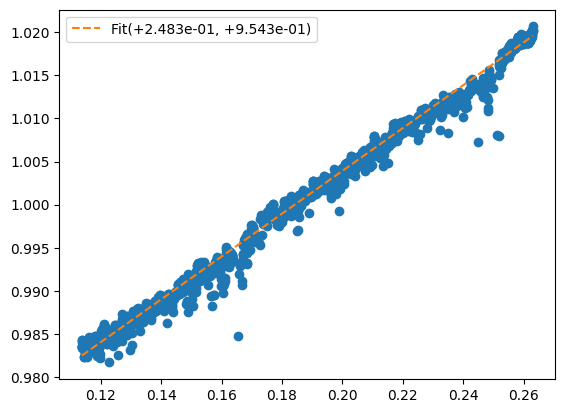

In [7]:
m_ = m.filter(regex="(dt_)?\d+")

chid = 0

muA = remove_top_bottom_x_percent((m_[chid] / attrsA["nbx"]).values, 2)
muB = remove_top_bottom_x_percent((m_[f"dt_{chid}"] / attrsA["nbx"]).values, 2)


huber = HuberRegressor().fit(muB.reshape(-1, 1), muA/muB)
s = huber.coef_[0]
i = huber.intercept_

plt.plot(muB, muA/muB, "o")
plt.plot(muB, muB*s+i, "--", label=f"Fit({s:+.3e}, {i:+.3e})")
plt.legend()
plt.show()

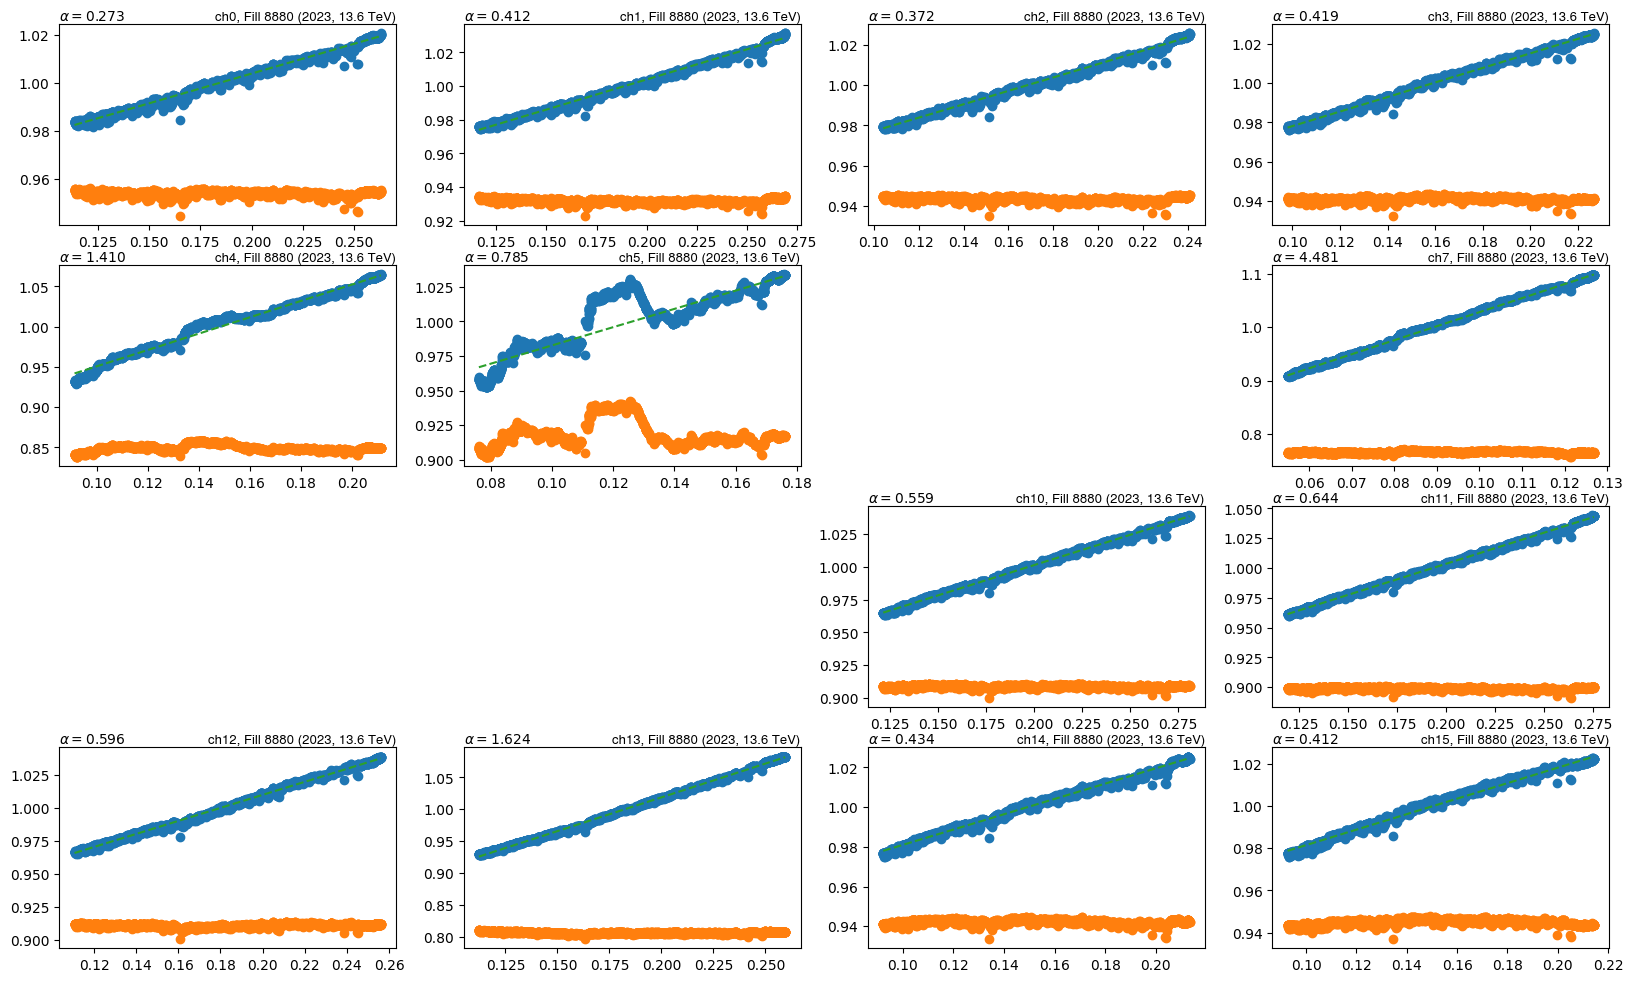

{0: {'slope': 0.24832009603778177,
  'intercept': 0.954257373631417,
  'alpha': 0.2726972878401071},
 1: {'slope': 0.358123367915862,
  'intercept': 0.932347000279824,
  'alpha': 0.41198130064738064},
 2: {'slope': 0.33159974617220406,
  'intercept': 0.9440370815235329,
  'alpha': 0.37207979072276937},
 3: {'slope': 0.3706608174537136,
  'intercept': 0.9410192852654623,
  'alpha': 0.4185811157450259},
 4: {'slope': 1.0163359185247425,
  'intercept': 0.8490592593091495,
  'alpha': 1.409812215877122},
 5: {'slope': 0.6593594245487591,
  'intercept': 0.9165952120432773,
  'alpha': 0.7848145563300842},
 7: {'slope': 2.626215852436263,
  'intercept': 0.7655462286359841,
  'alpha': 4.481130336540879},
 10: {'slope': 0.4614288735233457,
  'intercept': 0.9089466206886704,
  'alpha': 0.558506212025569},
 11: {'slope': 0.5208958513765924,
  'intercept': 0.8992465026761299,
  'alpha': 0.6441594518659239},
 12: {'slope': 0.49449445235656947,
  'intercept': 0.9111192893266292,
  'alpha': 0.59567715

In [9]:
m_ = m.filter(regex="(dt_)?\d+")

fig, axs = plt.subplots(4, 4, figsize=(20, 12))
axs = axs.flatten()

results = {}
for chid in range(16):
    ax = axs[chid]
    if chid in (6, 8, 9):
        ax.axis("off")
        continue

    muA = (m_[chid] / attrsA["nbx"]).values
    muB = (m_[f"dt_{chid}"] / attrsA["nbx"]).values

    muA = remove_top_bottom_x_percent(muA, 2)
    muB = remove_top_bottom_x_percent(muB, 2)

    huber = HuberRegressor().fit(muB.reshape(-1, 1), muA/muB)
    s = huber.coef_[0]
    i = huber.intercept_
    results[chid] = {
        "slope": s, "intercept": i, "alpha": s/i**2
    }
    
    muAc = sub_nl(muA, s/i**2, 1)

    hep.cms.label(
        exp="", ax=ax,
        llabel=f"$\\alpha = {s/i**2:.3f}$",
        rlabel=f"ch{chid}, Fill 8880 (2023, 13.6 TeV)"
    )

    ax.plot(muB, muA/muB, "o")
    ax.plot(muB, muAc/muB, "o")
    ax.plot(muB, muB*s+i, "--")

plt.show()
results